<a href="https://colab.research.google.com/github/cortes28/mini_food_comp_vision/blob/main/pyTorch_cd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use pyTorch with custom Dataset

Apply custom datasets to PyTorch to solve problems and to discover patterns within data to make predictions.

Many problems that can be solved with Machine Learning! Vision, text, image, recommendation, classification -> Each has a domain within PyTorch (libraries) for existing data loading functions.

Following the Course of understanding Deep Learning with PyTorch from https://youtu.be/V_xro1bcAuA

In [2]:
## Import current appropiate libaries
import torch
from torch      import nn

torch.__version__

'2.0.1+cu118'

In [3]:
# Set agnostic code to use the appropiate device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Gettign custom data

The dataset will be from Food101 dataset that hore than 101 different classes of food and 1000 images per class

We will base our project based on a subset of this dataset.

In [4]:
import requests
import zipfile
from pathlib import Path

# setup path to wehre the data is being stored
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"


#Check if the path is there.
if image_path.is_dir():
  print(f"{image_path} directory already exists! No need to download...\n")
else:
  print(f"{image_path} does not exist, creating one at {image_path}")
  image_path.mkdir(parents=True, exist_ok=True)

# Download the appropiate data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f" Downloading the dataset...")
  f.write(request.content)

  # Unzip the data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping the pizza_steak_sushi.zip dataset...")
    zip_ref.extractall(image_path)


data/pizza_steak_sushi does not exist, creating one at data/pizza_steak_sushi
Unzipping the pizza_steak_sushi.zip dataset...


# 2. Data Preperation

In [5]:
import os


def walk_thru_dir(dir_path):
  """ Walks through dir_path returing its contents...."""
  print(f"The path given was {dir_path}")

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} in {dirpath}.")

# image path is composed of `data_path / "pizza_steak_sushi"` where datapath is data/ -> entire thing is `data/pizza_steak_sushi`
walk_thru_dir(image_path)

The path given was data/pizza_steak_sushi
there are 2 directories and 0 in data/pizza_steak_sushi.
there are 3 directories and 0 in data/pizza_steak_sushi/test.
there are 0 directories and 19 in data/pizza_steak_sushi/test/steak.
there are 0 directories and 25 in data/pizza_steak_sushi/test/pizza.
there are 0 directories and 31 in data/pizza_steak_sushi/test/sushi.
there are 3 directories and 0 in data/pizza_steak_sushi/train.
there are 0 directories and 75 in data/pizza_steak_sushi/train/steak.
there are 0 directories and 78 in data/pizza_steak_sushi/train/pizza.
there are 0 directories and 72 in data/pizza_steak_sushi/train/sushi.


In [6]:
# setup training and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

print(f"train_dir: |{train_dir}|\ntest_dir:  |{test_dir}|")

train_dir: |data/pizza_steak_sushi/train|
test_dir:  |data/pizza_steak_sushi/test|


## 2.1 Visualizing

Get all of the image paths and pick a random image using a random function. Also get the image class name using `pathlib.Path.parent.stem`.
Since we are working with images, let's open the image with Python's PIL -> show the image and print metadata.



In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

random image path: data/pizza_steak_sushi/train/pizza/2702825.jpg
Image class: pizza
image height: 512
image width: 512


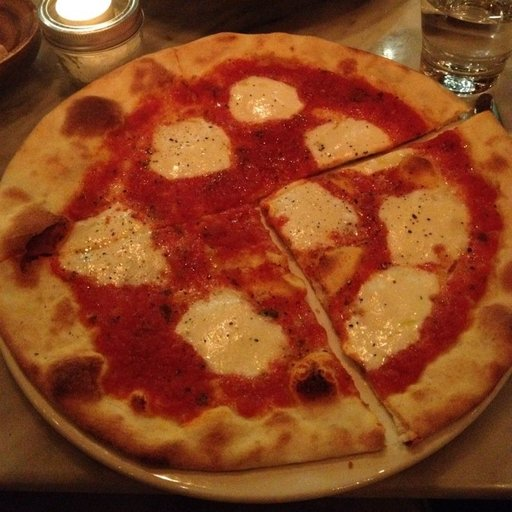

In [8]:
import  random
from    PIL    import Image

# Set seed
# random.seed(2)

# get the image paths (we are in `data/pizza_steak_sushi` already) * (test/train) / * (pizza/steak/sushi) / *.jpg (grabs all images  .jpg)
image_path_list = list(image_path.glob("*/*/*.jpg"))

# look at a random image
rdm_image_path = random.choice(image_path_list)

# image class from path name as its either pizza, sushi, steak
image_class  = rdm_image_path.parent.stem

# look at image
img = Image.open(rdm_image_path)

# print data of image (meta image)
print(f"random image path: {rdm_image_path}")
print(f"Image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")
# Prints the random image that we chose
img

(-0.5, 511.5, 511.5, -0.5)

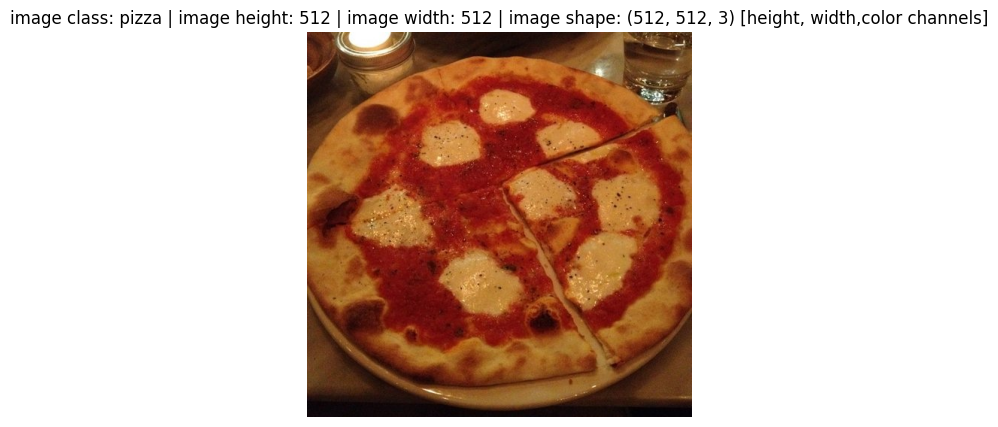

In [9]:
# plot an image with matplotlib
import matplotlib.pyplot as plt
import numpy             as np

img_np = np.asarray(img)
plt.figure(figsize=(5,5))
plt.imshow(img_np)
plt.title(f"image class: {image_class} | image height: {img.height} | image width: {img.width} | image shape: {img_np.shape} [height, width,color channels]")
plt.axis(False)

# 3. Transforming data into tensors

Before moving forward, have to move it towards a tensor to work with PyTorch. Into a numerical representation of images.
Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.Dataloader`, we'll call these `Dataset` and `DataLoader`.

In [10]:
import torch
from   torch.utils.data import DataLoader
from   torchvision      import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Help to get the images ready to be used for the model (training/testing/using)


In [11]:
# Write a transform for image
data_transforms = transforms.Compose([
  # Resize the image
  transforms.Resize(size=(64,64)),
  # Flip the image randomly to get more diversity in the data
  transforms.RandomHorizontalFlip(p=.5),
  # Turn the image into a torch Tensor
  transforms.ToTensor()
])

In [12]:
img_tensor = data_transforms(img)
# Transformed image,   type of tensor, img_np shape
img_tensor.shape,    img_tensor.dtype, img_np.shape

(torch.Size([3, 64, 64]), torch.float32, (512, 512, 3))

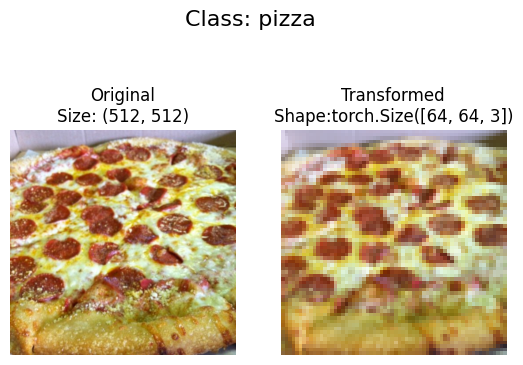

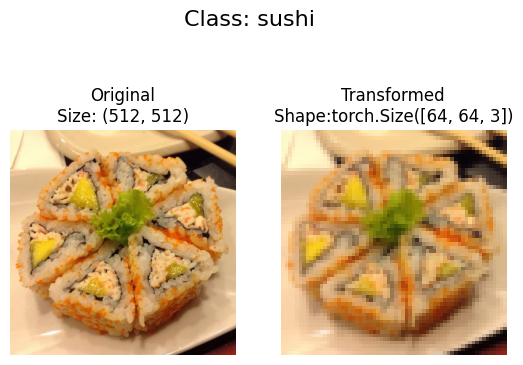

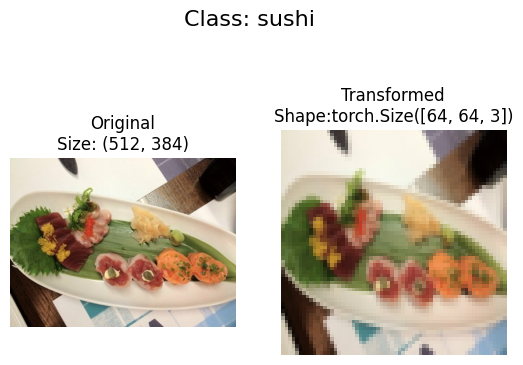

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects images at random from a path of iamges and loads/transforms them. Then it
  plots the original images to the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transfform and plot target image
      transformed_image = transform(f).permute(1, 2, 0)    # needs matplotlib (permute makes the dimension (0,1,2)-> (1, 2, 0)) Makes the color channels last (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape:{transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transforms,
                        n=3,
                        seed=None)


# 4. Loading image data using `ImageLoader`

Can load image classificaiton data using `torchvision.datasets.ImageFolder`

In [14]:
# Using ImageFolder
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms, # transforms that occurs on the data
                                  target_transform=None      # transform for the label/target
                                  )

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get the class name as a list
class_names = train_data.classes
# get class names as a dictionary
class_dict = train_data.class_to_idx
class_names, class_dict, len(train_data), len(test_data)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2}, 225, 75)

In [16]:
train_data.samples[:5]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)]

In [17]:
# Index on the train_data datset to get a simple image and label
image, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n {image}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"Image shape:    {image.shape}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"Image datatype: {image.dtype}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"Image label:    {label}")
print(f"~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

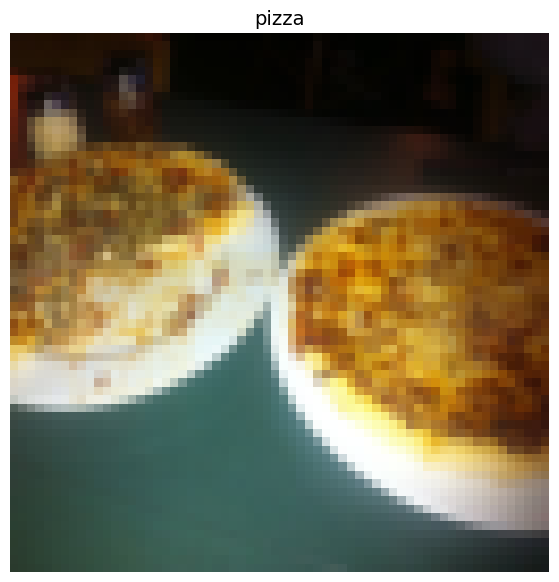

In [18]:
# Rearrange the order of dimensions as matplotlib like the color channels being last
img_perm = image.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {image.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_perm.shape} -> [height, width, color_channels]")

# Plot the iamge
plt.figure(figsize=(10, 7))
plt.imshow(img_perm)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

## 4.1 Turn loaded images to `DataLoader`

A `DataLoader` is going to help us turn out `dataset` into iterables and we can customize the `batch_size` so our model can see a certain amount (based on batch size) of images at a time.

In [19]:
import os
os.cpu_count()

2

In [20]:
# Turn the data into DataLoaders (train_data/test_data are already set to tensors)
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,     # the batch size that will be used
                              num_workers=1,             # use the available cpus (only 1 for now)
                              shuffle=True               # shuffles up the test datapoints
                              )
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ae445f2e260>,
 <torch.utils.data.dataloader.DataLoader at 0x7ae445f2ed10>)

In [21]:
len(train_dataloader), len(test_dataloader), len(train_data), len(test_data)

(225, 75, 225, 75)

In [22]:
image, label = next(iter(train_dataloader))

# Batch size will be 1... can change batch size
print(f"Image shape: {image.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5 Load the data with a custom 'Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can Create a `Dataset` out of almost anything
* Not limited to PyTorch prebuilt `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often requires in us writing more code, which could be prone to erros or performance issues


In [23]:
import os
import pathlib
import torch
from   PIL              import Image
from   torch.utils.data import dataset
from   torchvision      import transforms
from   typing           import Tuple, Dict, List

In [24]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error is the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.



In [25]:
# setup the path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# get the class names from the class
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """
  Find the class folder names in a target directory.
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f" Couldn't Find any classes in |{directory}|")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than string for labels)
  # maps the class name with the index in a dictionary
  class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
  return classes, class_to_idx


In [27]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target diretory (diretory we want to get data from)
3. Transform  if we'd like to transform our data.
4. Create several attributes:
  * paths - paths of our images
  * transform - the transformm we'd like to use
  * classes - a list of the target classes
  * class_to_idx - a dict of the target classes mapped to integer labels
5. Create a function to `load_images()`, this function will open an image
6. Overwrite the `__len()__` method to return the length of our datase
7. Overwrite the `getitem()__` method to return a given sample when passed an index



In [28]:
# Write a custom dataset class
from torch.utils.data import Dataset

#1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  #2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform=None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)


  # 4. Create a function to load images
  def load_image(self, index: int) ->Image.Image:
    "Opens an image path via a path and returns it"
    image_path = self.paths[index]
    return Image.open(image_path)


  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Returns the total number of samples"
    return len(self.paths)


  # 6 Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name        # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if neccesary
    if self.transform:
      return self.transform(img), class_idx           # Return data, label (X, y)
    else:
      return img, class_idx                           # Return untransformed image and label



In [29]:
# transform
from torchvision import transforms

train_transforms = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.RandomHorizontalFlip(p=0.5),   # Flip is added to add variety to the training data
  transforms.ToTensor()
])

# No need to transform it with a random horizontal flip
test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [30]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

In [31]:
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ae5211cef50>,
 <__main__.ImageFolderCustom at 0x7ae5211cf130>)

In [32]:
len(train_data), len(train_data_custom), len(test_data), len(test_data_custom)

(225, 225, 75, 75)

In [33]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
try:
  assert train_data_custom.classes == train_data.classes
  print(f"train_data_custom.classes and train_data.classes are the same")
except:
  print(f"train_data_custom.classes and train_data.classes are not the same")

try:
  assert test_data_custom.classes == test_data.classes
  print(f"test_data_custom.classes and test_data.classes are the same")
except:
  print(f"test_data_custom.classes and test_data.classes are not the same")

train_data_custom.classes and train_data.classes are the same
test_data_custom.classes and test_data.classes are the same


### 5.3 Create a function to display random images

1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To prevent the display getting out of hand, let's cap the number of images to see at 10.
3. Set the random seed for reproducibility
4. Get a list of random sample indexes form the target dataset
5. Setup a matplotlib plot
6. Loop thorugh the random sample images and plot them with matplotlib
7. Make sure the dimensions of our images line up with matplotlib (HWC)

In [34]:
import matplotlib.pyplot as plt

# 1. make a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
  # 2. Adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For displaying purposes, 'n' won't be larger than 10, setting to 10 and removing shape display. ")

  # 3. set the seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes for n amount
  random_samples_idx = random.sample(range(len(dataset)), k = n)


  # 5 Setup plot
  plt.figure(figsize=(16, 8))

  # 6. Loop through random indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7 Adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0) # [color_channels, height, width] -> [height, width, color_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i + 1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)



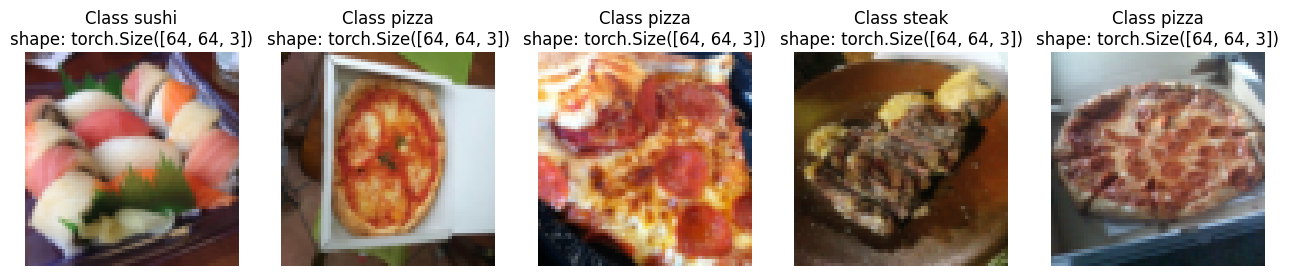

In [35]:
# display random images form ImageFolder created Dataset (python pre-build dataset)
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=None)

For displaying purposes, 'n' won't be larger than 10, setting to 10 and removing shape display. 


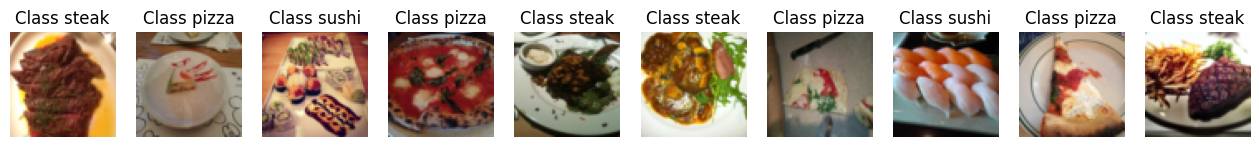

In [36]:
# display from random images fromthe ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=None)

### 5.4 Turn custom loaded images into `DataLoader's`

In [37]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,# how many cores will be used for the model)
                                     shuffle = True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ae445bdbc10>,
 <torch.utils.data.dataloader.DataLoader at 0x7ae445bdbcd0>)

In [38]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

#print out the shapes
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

Look at what is frequently used to train PyTorch vision models to add diversity and to give our model a more robust training process.

Hopefully results in the model that can work well with mix of augmentations that are possible with input data.

In [39]:
# Looking at trivial augment
from torchvision import transforms

train_transform = transforms.Compose([
  transforms.Resize(size=(224, 224)),                      # Larger size so it can have more information regarding the picture (more computing power needed!)
  transforms.TrivialAugmentWide(num_magnitude_bins=31),    # can be up to 31, the higher the more intense it is, Meant to add variation to the data by doing small to large alterations
  transforms.ToTensor()
])

test_tranform = transforms.Compose([
  transforms.Resize(size=(224,224)),
  transforms.ToTensor()
])

In [40]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/steak/1868005.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3873283.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/354513.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/690177.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/502076.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/100274.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/894825.jpg')]

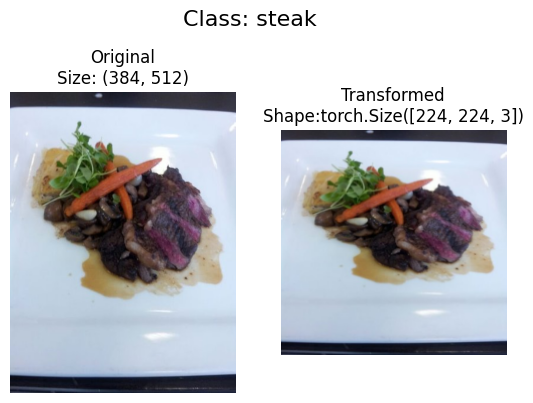

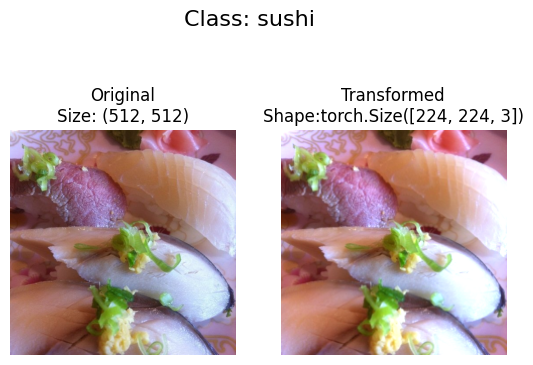

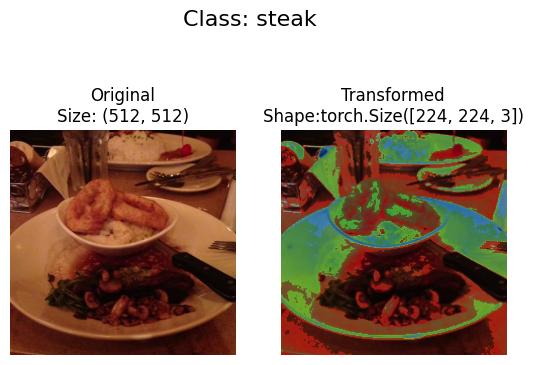

In [41]:
# Plot random transformed images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transform,
    n=3,
    seed=None
)

## 7. Model 0: TinyVGG without data augmentation first (no TrivialAugmentation for this model to see the difference)

Let's replicate TinyVGG architecture from the CNN explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [42]:
# Create a simple transform
simple_transforms = transforms.Compose([
  transforms.Resize(size=(64, 64)),     # Same size as in TinyVGG
  transforms.ToTensor()
])

In [43]:
# 1. Load and transform data
from torchvision import datasets


train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transforms)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                    transform=simple_transforms)

# 2. Turn the data into Dataloaders
import os
from torch.utils.data import DataLoader

# Set batch size and num of workers (cpu)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create DataLoaders
train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

### 7.2 Create TinyVGG model class

In [44]:
class TinyVGG(nn.Module):
  """
  Replicates that the Model architecture copying TinyVGG from CNN: Explainer
  """
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:

    super().__init__()
    #
    #
    # block 1
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)  # default stride value is the same as the kernel size
    )
    #
    #
    # block 2
    self.conv_block_2 = nn.Sequential(
    nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=0),
    nn.ReLU(),
    nn.Conv2d(in_channels=hidden_units,
              out_channels=hidden_units,
              kernel_size=3,
              stride=1,
              padding=0),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2,
                  stride=2)  # default stride value is the same as the kernel size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 13 * 13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(f"output of the first conv. block: {x.shape}\n")
    x = self.conv_block_2(x)
    #print(f"output of the second conv. block: {x.shape}\n")
    x = self.classifier(x)
    #print(f"output of the classifier layer: {x.shape}\n")
    return x
    # could do return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion

In [45]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,  # number of channels in our image
                  hidden_units=10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass on a simple image to test the model


In [46]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [47]:
# Try a forward pass [ERROR: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3) (inner numbers must be the same)] to troubleshoot appropiate number of in_features
"""
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )
~~~~~~~~~~~~~~~~~~~~~~~~~TO~~~~~~~~~~~~~~~~~~~~~~~~~
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units * 13* 13,
                  out_features=output_shape)
    )


"""
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through our model

In [48]:
try:
  import torchinfo

  from torchinfo import summary
  summary(model_0, input_size=[1, 3, 64, 64])
except:
  print(f"torchinfo not found...will pip installl")
  !pip3 install torchinfo
  import torchinfo

  from torchinfo import summary
  summary(model_0, input_size=[1, 3, 64, 64])

torchinfo not found...will pip installl


In [49]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loop functions

* `train_step()` - takes in a model and dataloader and trains the mdoel on a dataloader.
* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader


In [50]:
# Create a train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):

  # put the model in train mode
  model.train()

  # Setup train loss and train accuracy
  train_loss, train_acc = 0, 0

  # Loop thorugh data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send the data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)             # Outputs model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer the zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate the accuracy metric for the current batch
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get the average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc


In [51]:
# Create a test step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # put on eval mode
  model.eval()

  # setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # calculate the accuracy for the current batch
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels ==y).sum().item()/len(test_pred_labels))

    # Adjust metric to get average loss and accruacy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)

    return test_loss, test_acc

### 7.6 Creating a train() function to combine both test and train steps

In [52]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 4. update result dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

### 7.7 Train and evaluate model 0

In [53]:
from torch.optim import optimizer
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.1063 | Test loss: 1.0983 | Test acc: 0.3011
Epoch: 1 | Train loss: 1.0998 | Test loss: 1.0697 | Test acc: 0.5417
Epoch: 2 | Train loss: 1.0869 | Test loss: 1.0808 | Test acc: 0.4924
Epoch: 3 | Train loss: 1.0844 | Test loss: 1.0607 | Test acc: 0.5833
Epoch: 4 | Train loss: 1.0662 | Test loss: 1.0656 | Test acc: 0.5644
Total training time: 5.620 seconds


In [54]:
model_0_results

{'train_loss': [1.1063192635774612,
  1.099803775548935,
  1.0868676602840424,
  1.0844065248966217,
  1.0662392675876617],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.421875],
 'test_loss': [1.0983227094014485,
  1.0696964661280315,
  1.0807804663976033,
  1.0607001384099324,
  1.0655691623687744],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

### 7.8 Plot the loss curves of model 0

A **loss curve** is a way of trakcing your model's progress over time.



In [55]:
# Get model keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [56]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # gets the loss values of the results dicitonary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get acc values  of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how many epochs were used
  epochs = range(len(results["train_loss"]))

  # setup plot
  plt.figure(figsize=(15, 7))

  # plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

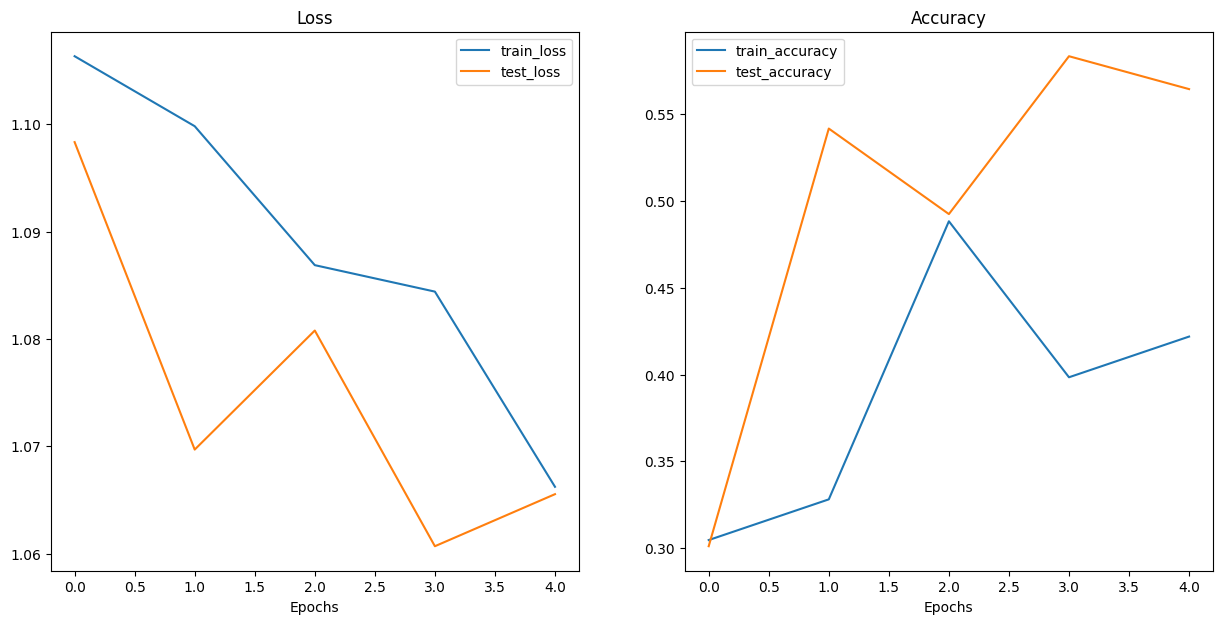

In [58]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before but now with DATA AUGMENTATION.

### 9.1 Create transform with data augmentation

In [59]:
# Craete training transform with TrivialAugment
from torchvision import transforms
train_transform_triv = transforms.Compose([
  transforms.Resize(size=(64,64)),
  transforms.TrivialAugmentWide(num_magnitude_bins=31),    # The intensity of how the augmentation will take affect
  transforms.ToTensor()
])

test_transform_sim = transforms.Compose([
  transforms.Resize(size=(64, 64)),
  transforms.ToTensor()
])

### 9.2 Create train and test Datasets and DataLoaders with data augmentation

In [60]:
# Turn image folders into datasets
from torchvision import datasets
train_data_augment = datasets.ImageFolder(root=train_dir,
                                          transform=train_transform_triv)
train_data_simple = datasets.ImageFolder(root=test_dir,
                                         transform=test_transform_sim)

In [61]:
# Turn Datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augment,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using teh same model architecture except this time we've augmented the training data

In [62]:
# Create model_1 and sedn it to the target device
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augment.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [97]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 10

# Setup loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

# timer to calculate the time
from timeit import default_timer as timer
start_time = timer()

#Train model
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time for model_1: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.0898 | Test loss: 1.0863 | Test acc: 0.3324
Epoch: 1 | Train loss: 1.0573 | Test loss: 1.0749 | Test acc: 0.3608
Epoch: 2 | Train loss: 1.0882 | Test loss: 1.0634 | Test acc: 0.4015
Epoch: 3 | Train loss: 1.0286 | Test loss: 1.0446 | Test acc: 0.3816
Epoch: 4 | Train loss: 1.0315 | Test loss: 0.9915 | Test acc: 0.4422
Epoch: 5 | Train loss: 1.1833 | Test loss: 1.0301 | Test acc: 0.3409
Epoch: 6 | Train loss: 0.9908 | Test loss: 0.9840 | Test acc: 0.5133
Epoch: 7 | Train loss: 0.9831 | Test loss: 1.0221 | Test acc: 0.4650
Epoch: 8 | Train loss: 0.9937 | Test loss: 0.9742 | Test acc: 0.4318
Epoch: 9 | Train loss: 0.9984 | Test loss: 0.9836 | Test acc: 0.4337
Total training time for model_1: 12.453 seconds


In [64]:
model_1_results

{'train_loss': [1.104913741350174,
  1.079245999455452,
  1.1276210248470306,
  1.0821891725063324,
  1.1019844561815262],
 'train_acc': [0.25, 0.42578125, 0.3046875, 0.42578125, 0.3046875],
 'test_loss': [1.1016944646835327,
  1.1066156228383381,
  1.1020899216334026,
  1.0923233429590862,
  1.0918800830841064],
 'test_acc': [0.2604166666666667,
  0.33996212121212127,
  0.35984848484848486,
  0.35984848484848486,
  0.33996212121212127]}

### 9.4 Plot the new model

Look at the loss curves


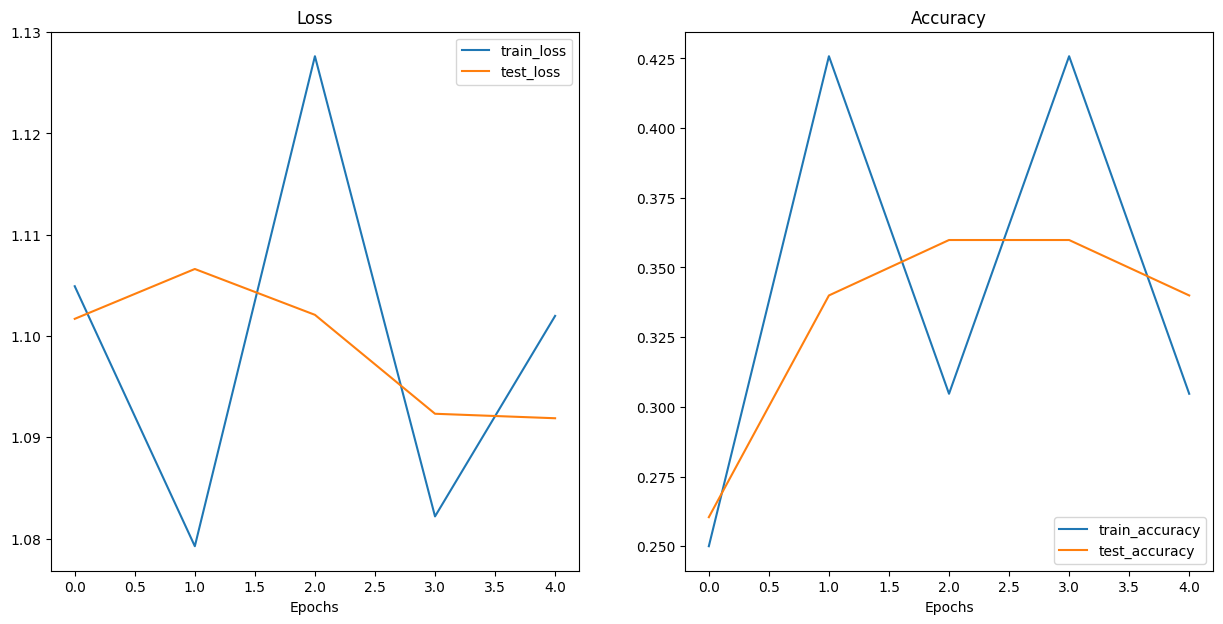

In [65]:
plot_loss_curves(model_1_results)

## 10. Compare the models

It is best to look at both models to compare how they differ


In [66]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098323,0.301136
1,1.099804,0.328125,1.069696,0.541667
2,1.086868,0.488281,1.080780,0.492424
3,1.084407,0.398438,1.060700,0.583333
4,1.066239,0.421875,1.065569,0.564394


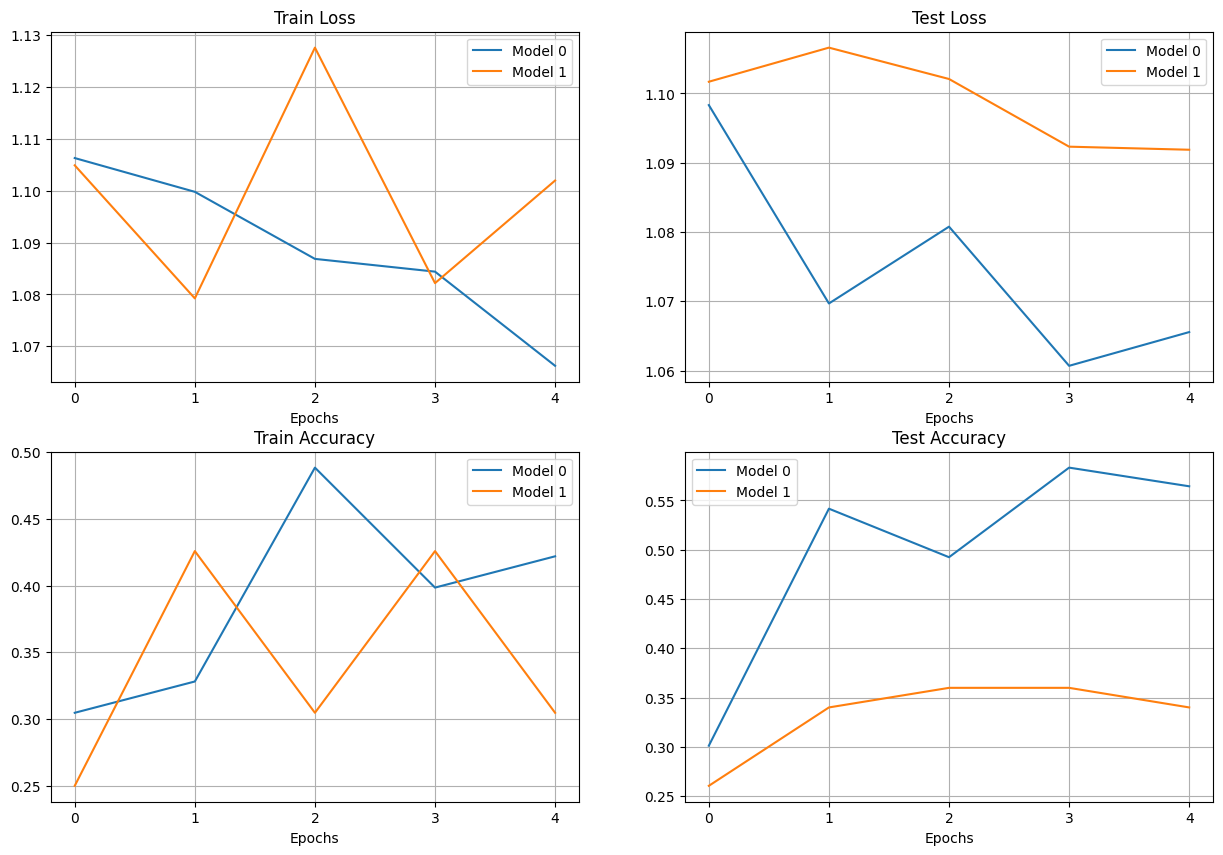

In [76]:
import matplotlib.ticker as mticker
# Setup a plot
plt.figure(figsize=(15,10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss

plt.subplot(2,2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.grid()
plt.legend()

# Plot test loss

plt.subplot(2,2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.grid()
plt.legend()

# Plot train accuracy

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.grid()
plt.legend()

# Plot test accuracy

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.grid()
plt.legend()

In [77]:
# Download a custom image
import requests

# setup a custom image path
custom_image_path = data_path /"04-pizza-data.jpeg"

# Download the iamge if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}...")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exists")

Downloadding data/04-pizza-data.jpeg...


### Loading a custom imgae wtih PyTorch

We have to make sure our custom image is in the same format as the data our model was trained on.

* In tensor form datatype (torch.float32)
* shape (64, 64, 3)
* Device (CUDA/CPU)

In [81]:
import torchvision

# Read custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8, custom_image_uint8.shape, custom_image_uint8.dtype

(tensor([[[154, 173, 181,  ...,  21,  18,  14],
          [146, 165, 181,  ...,  21,  18,  15],
          [124, 146, 172,  ...,  18,  17,  15],
          ...,
          [ 72,  59,  45,  ..., 152, 150, 148],
          [ 64,  55,  41,  ..., 150, 147, 144],
          [ 64,  60,  46,  ..., 149, 146, 143]],
 
         [[171, 190, 193,  ...,  22,  19,  15],
          [163, 182, 193,  ...,  22,  19,  16],
          [141, 163, 184,  ...,  19,  18,  16],
          ...,
          [ 55,  42,  28,  ..., 107, 104, 103],
          [ 47,  38,  24,  ..., 108, 104, 102],
          [ 47,  43,  29,  ..., 107, 104, 101]],
 
         [[119, 138, 147,  ...,  17,  14,  10],
          [111, 130, 145,  ...,  17,  14,  11],
          [ 87, 111, 136,  ...,  14,  13,  11],
          ...,
          [ 35,  22,   8,  ...,  52,  52,  48],
          [ 27,  18,   4,  ...,  50,  49,  44],
          [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8),
 torch.Size([3, 4032, 3024]),
 torch.uint8)

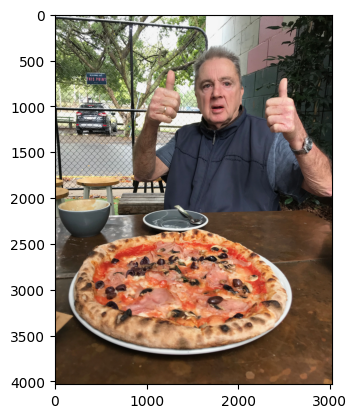

In [80]:
plt.imshow(custom_image_uint8.permute(1,2,0))


In [85]:
# Try to make a prediction on an image in uint8 format

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.

# transform pipeline to resize image
custom_image_transform = transforms.Compose([
  transforms.Resize(size=(64,64))
])

# Transform the image
custom_image_transformed = custom_image_transform(custom_image).unsqueeze(0)



model_1.eval()
with torch.inference_mode():
  pred = model_1(custom_image_transformed.to(device))
pred

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([[ 0.0850, -0.0793, -0.1234]], device='cuda:0')

Note, to make a prediction on a custom image we had to:

* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the data the model was trained on
* Make sure the image was the same shape as the data the model was trained on (1, 3, 64, 64)
* Make sure the image was on the same device (CUDA/CPU)

In [88]:
# Convert those logits -> prediction probabilities
custom_image_pred_probs = torch.softmax(pred, dim=1)
# Convert the prediction prob. to prediction labels
custom_image_pred_labels = torch.argmax(custom_image_pred_probs, dim=1)
custom_image_pred_labels

tensor([0], device='cuda:0')

In [90]:
# Convet the
class_names[custom_image_pred_labels]

'pizza'

### Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path and have our model predict on that image and plot the image + prediction

In [95]:
def pred_plot_image(model: torch.nn.Module,
                    image_path: str,
                    class_names: List[str] = None,
                    transform=None,
                    device=device):
  """Makes a prediction on a target image with a trained model and plots the image and prediction."""
  # Load in the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them in between 0-1
  target_image = target_image / 255.

  # Transform if neccessary:
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Turn on eval/inference mode and make a prediction
  model.eval()
  with torch.inference_mode():
    # Add an extra dimenson to the image (this is a batch dimension, e.g. our model will predict on batches of 1x image)
    target_image = target_image.unsqueeze(0)

    # Make a prediction on the iamge with an extra dimension
    target_image_pred = model(target_image.to(device))

    # Convert logits -> prediciton probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> predicition labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot the image alongside with the prediction and prediction probability
    plt.imshow(target_image.squeeze().permute(1,2,0)) # Remove batch dimension and rearrange the dimensions to plot it
    if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Probabilities: {target_image_pred_probs.max().cpu():.3f}"
    else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis("off")

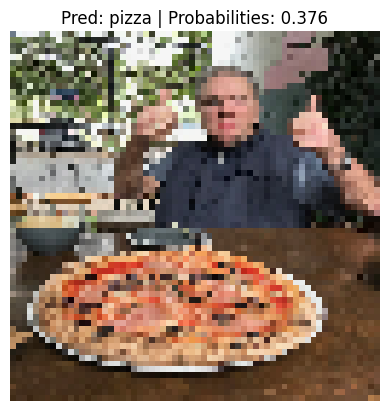

In [96]:
# Pred on our custom image
pred_plot_image(model=model_1,
                image_path=custom_image_path,
                class_names=class_names,
                transform=custom_image_transform,
                device=device)